<a href="https://colab.research.google.com/github/bsun1220/UCBTradingComp2022/blob/main/Yosemite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import zipfile
import functools

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
  uploaded = files.upload()
  if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
          "https://github.com/Kaggle/kaggle-api#api-credentials")
  with open(token_file, "wb") as f:
    f.write(uploaded["kaggle.json"])
  os.chmod(token_file, 600)

get_kaggle_credentials()

Saving kaggle.json to kaggle.json


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
!kaggle competitions download -c berkeleytradingcompetition2022

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [19]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.corr()["realized edge"]

trade id                0.001645
pred edge               0.567768
price                   0.087361
size                   -0.032801
sm sentiment            0.003891
sm sentiment (naive)    0.001847
realized edge           1.000000
pnl                     0.853414
Name: realized edge, dtype: float64

In [ ]:
#creating better predictor variables
train["diff"] = train["realized edge"] - train["pred edge"]
train["volume"] = train["price"] * train["size"]
train["sqrtvolume"] = np.sqrt(train["volume"])
train["accurate"] = np.abs(train["diff"]) < 3
train["adj sent"] = train["sm sentiment"] * train["sm sentiment"]

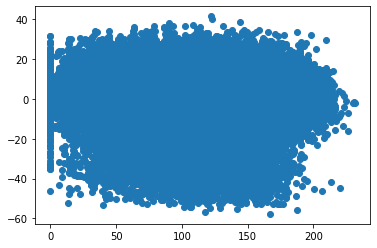

In [ ]:
plt.scatter(np.sqrt(train["volume"]), train["realized edge"])

In [ ]:
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,diff,volume,sqrtvolume,accurate,adj sent
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,-22.153537,3546.263314,59.550511,False,4.597768
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,-18.130767,16339.722286,127.826923,False,8874.046253
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,-0.439088,698.729497,26.433492,True,760.220970
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,-17.505768,5927.097947,76.987648,False,2026.852127
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,-7.358012,6829.276185,82.639435,False,509.659476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,-5.038477,14547.067809,120.611226,False,2235.659501
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,-3.146355,4906.284864,70.044878,False,3550.083327
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,-34.623619,4040.068898,63.561536,False,9222.857242
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,-1.274313,12601.456213,112.256208,True,8232.440358


In [ ]:
counter_party_means = train.groupby(["counterparty"]).mean()["realized edge"]
counter_party_means

counterparty
HF   -4.788423
MF    1.414207
R     3.670736
Name: realized edge, dtype: float64

In [ ]:
train.loc[train["counterparty"] == "HF", "counter_coef"] = -4.788423
train.loc[train["counterparty"] == "MF", "counter_coef"] = 1.414207
train.loc[train["counterparty"] == "R", "counter_coef"] = 3.670736
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,diff,volume,sqrtvolume,accurate,adj sent,counter_coef
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,-22.153537,3546.263314,59.550511,False,4.597768,-4.788423
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,-18.130767,16339.722286,127.826923,False,8874.046253,-4.788423
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,-0.439088,698.729497,26.433492,True,760.220970,3.670736
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,-17.505768,5927.097947,76.987648,False,2026.852127,-4.788423
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,-7.358012,6829.276185,82.639435,False,509.659476,1.414207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,-5.038477,14547.067809,120.611226,False,2235.659501,3.670736
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,-3.146355,4906.284864,70.044878,False,3550.083327,1.414207
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,-34.623619,4040.068898,63.561536,False,9222.857242,3.670736
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,-1.274313,12601.456213,112.256208,True,8232.440358,3.670736


In [ ]:
train.groupby(["stock", "location"]).describe()["diff"]

count       mean       std  ...        50%       75%        max
stock location                                ...                                
A     CSE        8042.0 -11.282128  7.436591  ... -10.236410 -6.653138   4.150417
      NASDAQ    16189.0  -6.974203  7.561850  ...  -5.883433 -2.323716  11.306417
      NYSE      16028.0  -6.356082  7.546595  ...  -5.245978 -1.738660  12.046831
B     CSE       11915.0 -12.605330  7.254049  ... -11.673210 -8.229869   4.423939
      NASDAQ    23929.0  -8.063833  7.109140  ...  -7.210267 -3.663770   9.530074
      NYSE      24030.0  -7.643819  7.291607  ...  -6.734187 -3.231894   8.947583
C     CSE       14040.0  -9.887922  7.377837  ...  -8.800539 -5.344170   8.524991
      NASDAQ    27972.0  -5.338244  7.480908  ...  -4.238517 -0.761319  11.125117
      NYSE      27804.0  -4.872110  7.551211  ...  -3.780667 -0.221782  13.598749
D     CSE        6050.0  -8.526265  7.892486  ...  -7.091979 -3.226801   6.992607
      NASDAQ    12088.0  -4.291540  8.124665  ...  -2.838048  1.087064  17.777172
      NYSE      11913.0  -3.727573  7.973335  ...  -2.288485  1.608147  13.098889

[12 rows x 8 columns]

In [ ]:
train.groupby(["counterparty"]).describe()["diff"]

,count,mean,std,min,25%,50%,75%,max
counterparty,,,,,,,,
HF,39955.0,-12.795402,4.790378,-36.208490,-15.570667,-12.396322,-9.503075,2.961033
MF,90056.0,-6.575508,4.484472,-31.761234,-9.207761,-6.272600,-3.545720,9.796031
R,69989.0,-4.292371,10.530231,-65.246400,-5.317261,-1.719363,1.224690,17.777172


In [ ]:
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,diff,volume,sqrtvolume,accurate,counter_coef
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,-22.153537,3546.263314,59.550511,False,-4.788423
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,-18.130767,16339.722286,127.826923,False,-4.788423
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,-0.439088,698.729497,26.433492,True,3.670736
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,-17.505768,5927.097947,76.987648,False,-4.788423
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,-7.358012,6829.276185,82.639435,False,1.414207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,-5.038477,14547.067809,120.611226,False,3.670736
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,-3.146355,4906.284864,70.044878,False,1.414207
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,-34.623619,4040.068898,63.561536,False,3.670736
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,-1.274313,12601.456213,112.256208,True,3.670736


In [ ]:
# MODELLING SECTION

In [ ]:
X = train[['sqrtvolume', 'counter_coef', 'pred edge', 'sm sentiment']]
X = sm.add_constant(X)
model = sm.OLS(train['realized edge'], X).fit()
predictions = model.predict(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          realized edge   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                 3.870e+04
Date:                Sat, 12 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:15:39   Log-Likelihood:            -6.7713e+05
No. Observations:              200000   AIC:                         1.354e+06
Df Residuals:                  199995   BIC:                         1.354e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.3599      0.053    -82.485      0.000      -4.464      -4.256
sqrtvolume      -0.0260      0.000    -61.928      0.000      -0.027      -0.025
counter_coef     0.9943      0.005    189.290      0.000       0.984       1.005
pred edge        0.8976      0.003    338.522      0.000       0.892       0.903
sm sentiment     0.0008      0.000      3.018      0.003       0.000       0.001
==============================================================================
Omnibus:                   129546.192   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1868474.690
Skew:                          -2.948   Prob(JB):                         0.00
Kurtosis:                      16.764   Cond. No.                         378.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
np.sum(predictions[predictions > 0])

587675.6677692463

In [ ]:
np.unique(train["location"])

array(['CSE', 'NASDAQ', 'NYSE'], dtype=object)

In [ ]:
tmp = train[predictions > 0]
for i in list('ABCD'):
    tmp2 = tmp[tmp['stock']==i]
    print('Total pnl of {} over {} trades on stock {}, ratio {}'.format(np.sum(tmp2['pnl']), len(tmp2), i, np.sum(tmp2['pnl'])/len(tmp2)))

NameError: ignored

In [ ]:
train.groupby(["location"]).mean()["realized edge"]


location
CSE      -2.790635
NASDAQ    1.673400
NYSE      2.137691
Name: realized edge, dtype: float64

In [ ]:
train["stock_coef"] = 0
train.loc[train["stock"] == "A", "stock_coef"] = 6.218583015870816
train.loc[train["stock"] == "B", "stock_coef"] = 4.391465206802396
train.loc[train["stock"] == "C", "stock_coef"] = 7.847250551564178
train.loc[train["stock"] == "D", "stock_coef"] = 8.901812159153453
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,diff,volume,sqrtvolume,accurate,adj sent,counter_coef,stock_coef
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,-22.153537,3546.263314,59.550511,False,4.597768,-4.788423,4.391465
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,-18.130767,16339.722286,127.826923,False,8874.046253,-4.788423,7.847251
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,-0.439088,698.729497,26.433492,True,760.220970,3.670736,4.391465
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,-17.505768,5927.097947,76.987648,False,2026.852127,-4.788423,4.391465
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,-7.358012,6829.276185,82.639435,False,509.659476,1.414207,7.847251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,-5.038477,14547.067809,120.611226,False,2235.659501,3.670736,4.391465
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,-3.146355,4906.284864,70.044878,False,3550.083327,1.414207,7.847251
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,-34.623619,4040.068898,63.561536,False,9222.857242,3.670736,8.901812
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,-1.274313,12601.456213,112.256208,True,8232.440358,3.670736,4.391465


In [ ]:
train.loc[train["location"] == "CSE", "loc_coef"] = -2.790635
train.loc[train["location"] == "NASDAQ", "loc_coef"] = 1.673400
train.loc[train["location"] == "NYSE", "loc_coef"] = 2.137691
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,diff,volume,sqrtvolume,accurate,adj sent,counter_coef,stock_coef,loc_coef
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,-22.153537,3546.263314,59.550511,False,4.597768,-4.788423,4.391465,-2.790635
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,-18.130767,16339.722286,127.826923,False,8874.046253,-4.788423,7.847251,-2.790635
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,-0.439088,698.729497,26.433492,True,760.220970,3.670736,4.391465,2.137691
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,-17.505768,5927.097947,76.987648,False,2026.852127,-4.788423,4.391465,-2.790635
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,-7.358012,6829.276185,82.639435,False,509.659476,1.414207,7.847251,1.673400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,-5.038477,14547.067809,120.611226,False,2235.659501,3.670736,4.391465,2.137691
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,-3.146355,4906.284864,70.044878,False,3550.083327,1.414207,7.847251,1.673400
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,-34.623619,4040.068898,63.561536,False,9222.857242,3.670736,8.901812,2.137691
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,-1.274313,12601.456213,112.256208,True,8232.440358,3.670736,4.391465,2.137691


In [ ]:
t_train = train[0:160000]
t_test = train[160000:200000]

X = t_train[['sqrtvolume', 'counter_coef', 'loc_coef', 'stock_coef', 'pred edge', "sm sentiment"]]
Xtest = t_test[['sqrtvolume', 'counter_coef', 'loc_coef', 'stock_coef', 'pred edge']]
X = sm.add_constant(X)
Xtest = sm.add_constant(Xtest)
model = sm.OLS(t_train['realized edge'], X).fit()
predictions = model.predict(Xtest)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


ValueError: ignored

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          realized edge   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 2.658e+04
Date:                Sat, 12 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:15:55   Log-Likelihood:            -5.3218e+05
No. Observations:              160000   AIC:                         1.064e+06
Df Residuals:                  159993   BIC:                         1.064e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -10.9579      0.087   -125.974      0.000     -11.128     -10.787
sqrtvolume      -0.0261      0.000    -58.963      0.000      -0.027      -0.025
counter_coef     0.9966      0.006    180.037      0.000       0.986       1.007
loc_coef         1.0103      0.009    113.333      0.000       0.993       1.028
stock_coef       0.8480      0.010     84.699      0.000       0.828       0.868
pred edge        0.8985      0.003    321.670      0.000       0.893       0.904
sm sentiment     0.0007      0.000      2.343      0.019       0.000       0.001
==============================================================================
Omnibus:                   120154.292   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2348656.090
Skew:                          -3.521   Prob(JB):                         0.00
Kurtosis:                      20.398   Cond. No.                         594.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
train["pos"] = np.where(train["dir"] == "S", -1, 1)

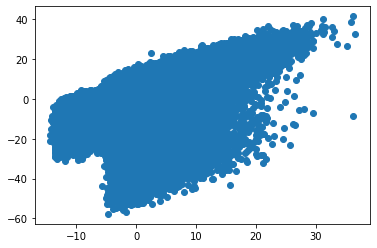

In [ ]:
plt.scatter(predictions, train['realized edge'])

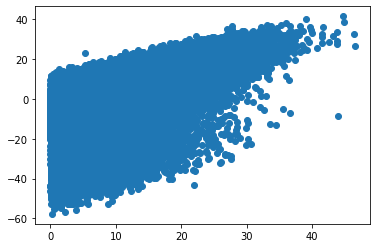

In [ ]:
plt.scatter(train['pred edge'], train['realized edge'])

In [ ]:
traded = t_test[predictions>0]
np.sum(traded['pnl'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


137790.78666131792

In [ ]:
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,diff,volume,sqrtvolume,accurate,adj sent,counter_coef,stock_coef,loc_coef
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,-22.153537,3546.263314,59.550511,False,4.597768,-4.788423,4.391465,-2.790635
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,-18.130767,16339.722286,127.826923,False,8874.046253,-4.788423,7.847251,-2.790635
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,-0.439088,698.729497,26.433492,True,760.220970,3.670736,4.391465,2.137691
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,-17.505768,5927.097947,76.987648,False,2026.852127,-4.788423,4.391465,-2.790635
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,-7.358012,6829.276185,82.639435,False,509.659476,1.414207,7.847251,1.673400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,-5.038477,14547.067809,120.611226,False,2235.659501,3.670736,4.391465,2.137691
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,-3.146355,4906.284864,70.044878,False,3550.083327,1.414207,7.847251,1.673400
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,-34.623619,4040.068898,63.561536,False,9222.857242,3.670736,8.901812,2.137691
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,-1.274313,12601.456213,112.256208,True,8232.440358,3.670736,4.391465,2.137691


In [ ]:
X = train[['sqrtvolume', 'counter_coef', 'pred edge', 'adj sent', "stock_coef", "loc_coef"]]
X = sm.add_constant(X)
model = sm.OLS(train['realized edge'], X).fit()
predictions = model.predict(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          realized edge   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 3.872e+04
Date:                Sat, 12 Feb 2022   Prob (F-statistic):               0.00
Time:                        21:27:28   Log-Likelihood:            -6.5737e+05
No. Observations:              200000   AIC:                         1.315e+06
Df Residuals:                  199993   BIC:                         1.315e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8.8474      0.077   -115.603      0.000      -8.997      -8.697
sqrtvolume      -0.0263      0.000    -69.072      0.000      -0.027      -0.026
counter_coef     0.9982      0.005    209.760      0.000       0.989       1.008
pred edge        0.8962      0.002    373.111      0.000       0.892       0.901
adj sent        -0.0006   4.86e-06   -129.590      0.000      -0.001      -0.001
stock_coef       0.8508      0.009     98.802      0.000       0.834       0.868
loc_coef         1.0043      0.008    131.140      0.000       0.989       1.019
==============================================================================
Omnibus:                   128088.077   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1800203.603
Skew:                          -2.911   Prob(JB):                         0.00
Kurtosis:                      16.495   Cond. No.                     2.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
train

,trade id,pred edge,stock,location,price,size,dir,counterparty (naive),sm sentiment (naive)
0,0,11.785579,C,NYSE,14.727382,1346.0,B,MF,9.119066
1,1,8.490506,C,CSE,15.016002,882.0,S,MF,-48.652384
2,2,0.687709,C,NYSE,15.169420,423.0,B,MF,3.536848
3,3,7.352720,D,CSE,2026.572586,8.0,B,MF,48.257293
4,4,2.995660,C,NYSE,15.027723,523.0,B,MF,-66.590908
...,...,...,...,...,...,...,...,...,...
99995,99995,18.867160,D,NYSE,1995.388892,1.0,B,HF,-85.018229
99996,99996,11.175501,B,NASDAQ,99.420082,51.0,S,MF,43.210479
99997,99997,2.351071,A,NASDAQ,40.410974,270.0,S,HF,29.156088
99998,99998,0.043775,C,NYSE,15.090556,787.0,B,MF,-91.163595


In [ ]:
test

,trade id,pred edge,stock,location,price,size,dir,counterparty (naive),sm sentiment (naive)
0,0,11.785579,C,NYSE,14.727382,1346.0,B,MF,9.119066
1,1,8.490506,C,CSE,15.016002,882.0,S,MF,-48.652384
2,2,0.687709,C,NYSE,15.169420,423.0,B,MF,3.536848
3,3,7.352720,D,CSE,2026.572586,8.0,B,MF,48.257293
4,4,2.995660,C,NYSE,15.027723,523.0,B,MF,-66.590908
...,...,...,...,...,...,...,...,...,...
99995,99995,18.867160,D,NYSE,1995.388892,1.0,B,HF,-85.018229
99996,99996,11.175501,B,NASDAQ,99.420082,51.0,S,MF,43.210479
99997,99997,2.351071,A,NASDAQ,40.410974,270.0,S,HF,29.156088
99998,99998,0.043775,C,NYSE,15.090556,787.0,B,MF,-91.163595


In [20]:
def create_cols(df):
  df["sqrtvolume"] = np.sqrt(df["size"] * df["price"])
  df["adj sent"] = df["sm sentiment (naive)"] * df["sm sentiment (naive)"]

  df["stock_coef"] = 0
  df.loc[train["stock"] == "A", "stock_coef"] = 6.218583015870816
  df.loc[train["stock"] == "B", "stock_coef"] = 4.391465206802396
  df.loc[train["stock"] == "C", "stock_coef"] = 7.847250551564178
  df.loc[train["stock"] == "D", "stock_coef"] = 8.901812159153453

  df["counter_coef"] = 0
  df.loc[df["counterparty (naive)"] == "HF", "counter_coef"] = -4.788423
  df.loc[df["counterparty (naive)"] == "MF", "counter_coef"] = 1.414207
  df.loc[df["counterparty (naive)"] == "R", "counter_coef"] = 3.670736

  df.loc[df["location"] == "CSE", "loc_coef"] = -2.790635
  df.loc[df["location"] == "NASDAQ", "loc_coef"] = 1.673400
  df.loc[df["location"] == "NYSE", "loc_coef"] = 2.137691

  return df

def train_create_cols(df):
  df["sqrtvolume"] = np.sqrt(df["size"] * df["price"])
  df["adj sent"] = df["sm sentiment"] * df["sm sentiment"]

  df["stock_coef"] = 0
  df.loc[train["stock"] == "A", "stock_coef"] = 6.218583015870816
  df.loc[train["stock"] == "B", "stock_coef"] = 4.391465206802396
  df.loc[train["stock"] == "C", "stock_coef"] = 7.847250551564178
  df.loc[train["stock"] == "D", "stock_coef"] = 8.901812159153453

  df["counter_coef"] = 0
  df.loc[df["counterparty"] == "HF", "counter_coef"] = -4.788423
  df.loc[df["counterparty"] == "MF", "counter_coef"] = 1.414207
  df.loc[df["counterparty"] == "R", "counter_coef"] = 3.670736

  df.loc[df["location"] == "CSE", "loc_coef"] = -2.790635
  df.loc[df["location"] == "NASDAQ", "loc_coef"] = 1.673400
  df.loc[df["location"] == "NYSE", "loc_coef"] = 2.137691

  return df


In [21]:
train_create_cols(train)
train[['sqrtvolume', 'counter_coef', 'pred edge', 'adj sent', "stock_coef", "loc_coef"]]

,sqrtvolume,counter_coef,pred edge,adj sent,stock_coef,loc_coef
0,59.550511,-4.788423,18.145986,4.597768,4.391465,-2.790635
1,127.826923,-4.788423,14.414018,8874.046253,7.847251,-2.790635
2,26.433492,3.670736,12.306395,760.220970,4.391465,2.137691
3,76.987648,-4.788423,0.553884,2026.852127,4.391465,-2.790635
4,82.639435,1.414207,5.020094,509.659476,7.847251,1.673400
...,...,...,...,...,...,...
199995,120.611226,3.670736,1.035089,2235.659501,4.391465,2.137691
199996,70.044878,1.414207,3.668662,3550.083327,7.847251,1.673400
199997,63.561536,3.670736,8.910650,9222.857242,8.901812,2.137691
199998,112.256208,3.670736,4.287823,8232.440358,4.391465,2.137691


In [59]:

X = train[['sqrtvolume', 'counter_coef', 'pred edge', 'adj sent', "stock_coef", "loc_coef"]]
X = sm.add_constant(X)
model = sm.OLS(train['realized edge'], X).fit()
predictions = model.predict(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
np.sum(train[predictions > 0]["pnl"])

767148.3388364015

In [23]:
create_cols(test)

,trade id,pred edge,stock,location,price,size,dir,counterparty (naive),sm sentiment (naive),sqrtvolume,adj sent,stock_coef,counter_coef,loc_coef
0,0,11.785579,C,NYSE,14.727382,1346.0,B,MF,9.119066,140.794376,83.157367,4.391465,1.414207,2.137691
1,1,8.490506,C,CSE,15.016002,882.0,S,MF,-48.652384,115.083072,2367.054431,7.847251,1.414207,-2.790635
2,2,0.687709,C,NYSE,15.169420,423.0,B,MF,3.536848,80.104086,12.509292,4.391465,1.414207,2.137691
3,3,7.352720,D,CSE,2026.572586,8.0,B,MF,48.257293,127.328633,2328.766333,4.391465,1.414207,-2.790635
4,4,2.995660,C,NYSE,15.027723,523.0,B,MF,-66.590908,88.653816,4434.349069,7.847251,1.414207,2.137691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,18.867160,D,NYSE,1995.388892,1.0,B,HF,-85.018229,44.669776,7228.099338,7.847251,-4.788423,2.137691
99996,99996,11.175501,B,NASDAQ,99.420082,51.0,S,MF,43.210479,71.206911,1867.145506,7.847251,1.414207,1.673400
99997,99997,2.351071,A,NASDAQ,40.410974,270.0,S,HF,29.156088,104.455555,850.077462,7.847251,-4.788423,1.673400
99998,99998,0.043775,C,NYSE,15.090556,787.0,B,MF,-91.163595,108.978288,8310.800968,6.218583,1.414207,2.137691


In [24]:
Y = test[['sqrtvolume', 'counter_coef', 'pred edge', 'adj sent', "stock_coef", "loc_coef"]]
Y = sm.add_constant(Y)
predictions = model.predict(Y)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
data = {'realized edge': predictions}
df = pd.DataFrame(data)
df.index.rename("trade id", inplace = True)
df


,realized edge
trade id,
0,5.255692
1,-0.469430
2,-3.050345
3,-4.727389
4,-1.051755
...,...
99995,6.378458
99996,7.889039
99997,-6.444849


In [56]:
df.to_csv("submission.csv")

In [57]:
!kaggle competitions submit -c berkeleytradingcompetition2022 -f submission.csv -m "Message"

100% 2.37M/2.37M [00:01<00:00, 1.35MB/s]
Successfully submitted to Berkeley Trading Competition Yosemite

In [62]:
df

,realized edge
trade id,
0,5.255692
1,-0.469430
2,-3.050345
3,-4.727389
4,-1.051755
...,...
99995,6.378458
99996,7.889039
99997,-6.444849


In [58]:
train

,trade id,pred edge,stock,location,price,size,dir,counterparty,counterparty (naive),sm sentiment,sm sentiment (naive),realized edge,pnl,sqrtvolume,adj sent,stock_coef,counter_coef,loc_coef
0,0,18.145986,B,CSE,98.507314,36.0,S,HF,MF,2.144241,-89.167775,-4.007551,-1.421183,59.550511,4.597768,4.391465,-4.788423,-2.790635
1,1,14.414018,C,CSE,14.935761,1094.0,S,HF,R,-94.202156,83.379633,-3.716749,-6.073064,127.826923,8874.046253,7.847251,-4.788423,-2.790635
2,2,12.306395,B,NYSE,99.818500,7.0,S,R,R,27.572105,27.572105,11.867307,0.829204,26.433492,760.220970,4.391465,3.670736,2.137691
3,3,0.553884,B,CSE,100.459287,59.0,B,HF,MF,-45.020574,-40.040991,-16.951884,-10.047548,76.987648,2026.852127,4.391465,-4.788423,-2.790635
4,4,5.020094,C,NASDAQ,15.209969,449.0,S,MF,HF,22.575639,22.575639,-2.337918,-1.596629,82.639435,509.659476,7.847251,1.414207,1.673400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199995,1.035089,B,NYSE,98.290999,148.0,S,R,R,47.282761,74.037358,-4.003388,-5.823755,120.611226,2235.659501,4.391465,3.670736,2.137691
199996,199996,3.668662,C,NASDAQ,15.003929,327.0,S,MF,MF,-59.582576,-66.851010,0.522307,0.256259,70.044878,3550.083327,7.847251,1.414207,1.673400
199997,199997,8.910650,D,NYSE,2020.034449,2.0,S,R,R,96.035708,96.035708,-25.712969,-10.388217,63.561536,9222.857242,8.901812,3.670736,2.137691
199998,199998,4.287823,B,NYSE,99.224065,127.0,S,R,MF,-90.732796,-90.732796,3.013510,3.797461,112.256208,8232.440358,4.391465,3.670736,2.137691
